In [43]:
import numpy as np
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.spatial.distance import euclidean
from sklearn.feature_selection import f_regression
from statsmodels.tsa.stattools import adfuller
from sklearn.manifold import TSNE
import hdbscan
import csv
import multiprocessing
import itertools
import operator
plt.style.use('fivethirtyeight')
from osgeo import gdal 
from subprocess import Popen
import numpy.ma as ma
from numpy import linalg as LA
from dtaidistance import dtw

In [3]:
from rasterio.transform import Affine

In [4]:
class Data():
    
    def __init__(self, filename1, filename2, pc=0.3):
        self.load(filename1, filename2, pc)
        
    def set_latitudes(self, latitudes):
        self.latitudes = latitudes
        
    def set_longitudes(self, longitudes):
        self.longitudes = longitudes
        
    def set_topo(self, topo):
        self.topo = topo
        
    def set_ns_mean_velocities(self, velocities):
        self.ns_mean_velocities = velocities
        
    def set_ew_mean_velocities(self, velocities):
        self.ew_mean_velocities = velocities
    
    def set_dates(self, dates):
        self.dates = dates
    
    def set_ns_displacements(self, ns_displacements):
        self.ns_displacements = ns_displacements
        
    def set_ew_displacements(self, ew_displacements):
        self.ew_displacements = ew_displacements
        
    def load(self, ns_file_path, ew_file_path, pc):
        ns_displacements, ew_displacements, booleans = [], [], []
        ns_infos, ns = self.load_component(ns_file_path)
        ew_infos, ew = self.load_component(ew_file_path)
        m = len(ns[0])
        
        mask = [(ns[n].isnull().sum().sum() / len(ns[0])) < pc for n in range(len(ns))]
        
        for n, components in enumerate(zip(ns, ew)):
            if ns[n].isnull().sum().sum() / m < pc:
                ns_displacements.append(components[0].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                ew_displacements.append(components[1].interpolate(limit_direction='both', inplace=False)['displacement'].values)
                booleans.append(False)
            else:
                booleans.append(True)
            
        self.set_latitudes(ns_infos['Lat'].values[mask])
        self.set_longitudes(ns_infos['Lon'].values[mask])
        self.set_topo(ns_infos['Topo'].values[mask])
        self.set_ns_mean_velocities(ns_infos['Vel'].values[mask])
        self.set_ew_mean_velocities(ew_infos['Vel'].values[mask])
        self.set_ns_displacements(np.array(ns_displacements))
        self.set_ew_displacements(np.array(ew_displacements))
        self.set_dates(ns[0].index)
        
    #np.count_nonzero(np.isnan(data))
    def load_image_correlation(self, ns_fi, ew_filename):
        df_ns, df_ns_ts = self.load_component(ns_filename)
        df_ew, df_ew_ts = self.load_component(ew_filename)
        df_ew.rename(columns={'Vel': 'Vel_ew'}, inplace=True)
        df_ns.rename(columns={'Vel': 'Vel_ns'}, inplace=True)
        geo = pd.concat([df_ew[['id', 'Lat','Lon','Topo','Vel_ew']], df_ns[['Vel_ns']]], axis=1)
        return geo, df_ns_ts, df_ew_ts
        
    def load_component(self, filename):
        
        # numéro de la ligne ou commence les données
        num_start = 44
        # numéro de la ligne ou se trouve la liste des dates
        num_list_dates = 40
        # attributs présent dans les données
        columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
        # dictionnaire stockant les données
        data = {column: [] for column in columns}
        # liste des dates 
        indexes = []
        # series temporelles
        series = []
        # liste de dataframes
        df_series = []
        
        with open(filename) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=",")
            line_count = 1 
            for row in csv_reader:
                if line_count == num_list_dates:
                    indexes = [row[0].split(' ')[1]] + row[1:]
                if line_count >= num_start:
                    # extraction des premiers attributs
                    for i in range(len(columns)):
                        data[columns[i]].append(row[i])
                    # extraction de l'attribut TS(série temporelle)
                    series.append([float(v) for v in row[len(columns):]])
                line_count  += 1
            if len(indexes) != len(series[0]):
                print('Erreur : Les indexes et les valeurs ne correspondent pas')
            # convertir les index en date
            indexes = [d.strip()[0:8] for d in indexes]
            # créer une liste de dataframes, chacun contenant une série temporelle
            for serie in series:
                tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
                tmp_serie.sort_index(inplace=True)
                df_series.append(tmp_serie)
            # creer un dataframe pour les autres attributs
            df = pd.DataFrame(data)
            for column in df.columns:
                df[column] = pd.to_numeric(df[column], errors='coerce')
            df.set_index('id')
        return df, df_series

In [4]:
class Displacement():
    def __init__(self):
        pass
    
    def compute_velocity(self, displacement):
        return 0
    
    def test(self):
        return 0
    
    def is_mean_velocity_significant(self, displacements, days):
        # extraire X et y
        X = StandardScaler().fit_transform(displacements)
        # calculer la p-value de la regression lineaire
        _, pval = f_regression(X, days)
        return  pval[0]
    
    def compute_inst_vel(self, displacements, dates):
        diff_displacements, durations = self.prepare(displacements, dates)
        return np.divide(diff_displacements, durations)
    
    # TODO
    def is_stationary(self, displacement, alpha, freq='D'):
        resampled = displacement.resample(freq)
        interpolated = upsampled.interpolate(method='linear')
        return self.compute_adfuller(interpolated) < alpha
    
     # TODO
    def smooth(self, displacement, factor):
        std = math.sqrt(serie.var())
        for i in range(len(serie)):
            if abs(serie.iloc[i].displacement) > ampl*std:
                serie.iloc[i, serie.columns.get_loc('displacement')]= np.nan
        return serie.interpolate(limit_direction='both', inplace=False)
    
    def prepare(self, displacement, dates):
        durations = np.diff(dates) / np.timedelta64(1,'D')
        return self.transform_displacement(displacement), self.transform_date(dates)
    
    def transform_date(self, dates):
        temp = np.diff(np.array(dates))
        shifted = np.array([np.timedelta64(1, 'D') for n in range(temp.shape[0])])
        shifted[0:-1] = temp[1:]
        return (shifted + temp)[:-1] / np.timedelta64(1,'D')
    
    def transform_displacement(self, displacement):
        temp = np.diff(np.array(displacement))
        shifted = np.zeros(temp.shape[0])
        shifted[0:-1] = temp[1:]
        return np.add(temp, shifted)[:-1]
    
    def transform_dates_for_lnreg(self, dates):
        lnr_dates = np.cumsum( np.diff(data.dates) /  np.timedelta64(1,'D') )
        return np.insert(lnr_dates, 0, 0, axis=0)

In [6]:
class DataFromImageCorrelation():
    
    def __init__(self, data, raster_folder_name, dem_filename, pc=0.4, alpha=0.05, ref='wgs84'):
        self.data  = data
        self.compute_slope_map(raster_folder_name, dem_filename)
        self.compute_vlm_std()
        self.n_cores = multiprocessing.cpu_count()
        self.pc = pc
        self.ref = ref
        self.alpha = alpha
        self.velocities = []
        self.mask = np.array([])
    
    def compute_vel(self, ns_component, ew_component):
        return math.sqrt(ns_component * ns_component + ew_component * ew_component)
    
    def is_ns_mean_velocity_significant(self, n):
        displacement = self.data.ns_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_ew_mean_velocity_significant(self, n):
        displacement = self.data.ew_displacements[n].reshape(-1, 1)
        dates = Displacement().transform_dates_for_lnreg(self.data.dates)
        return Displacement().is_mean_velocity_significant(displacement, dates) < self.alpha
    
    def is_mean_velocity_significant(self, n):
        return self.is_ns_mean_velocity_significant(n) and self.is_ew_mean_velocity_significant(n)
    
    def is_moving(self, n, factor):
        ns_vel = data.ns_mean_velocities[n]
        ew_vel = data.ew_mean_velocities[n]
        return self.compute_vel(ns_vel, ew_vel) > factor * self.sigma
    
    def filter_by(self, factor, min_slope=5):
        vfunc = np.vectorize(self.is_to_select)
        self.mask = vfunc(np.arange(self.data.latitudes.shape[0]), factor, min_slope)

    def is_to_select(self, n, factor, min_slope):
        return (self.is_moving(n, factor) and
               self.is_ns_mean_velocity_significant(n) and
                self.is_ew_mean_velocity_significant(n))
    
    def filter_by_linear_reg(self):
        pass
                
    def compute_vlm_std(self):
        vfunc = np.vectorize(self.compute_vel)
        ns_velocities = self.data.ns_mean_velocities
        ew_velocities = self.data.ew_mean_velocities
        self.sigma = np.std(vfunc(ns_velocities, ew_velocities))
        
    def compute_inst_vels(self, series):
        with multiprocessing.Pool(self.n_cores) as p:
            results = p.map(Displacement().compute_inst_vel, series)
            return results
        
    def compute_velocities(self):
        if self.mask.shape[0] > 0:
            ns_displacements = self.data.ns_displacements[~np.array(self.mask)]
            ew_displacements = self.data.ew_displacements[~np.array(self.mask)]
            ns_vels = self.compute_inst_vels(ns_displacements)
            ew_vels = self.compute_inst_vels(ew_displacements)
            vfunc = np.vectorize(self.compute_vel)
            self.velocities = np.array([vfunc(ns, ew) for ns, ew in zip(ns_displacements, ew_displacements)])
                    
    def set_slope_map_path(self, slope_map_path):
        self.slope_map_path = slope_map_path
        
    def load_raster(self, raster_folder_name, raster_filename):
        return gdal.Open(raster_folder_name + '/' +  raster_filename)
        
    def compute_slope_map(self, raster_folder_name, dem_name):
        dem = None
        slope_map = None
        slope_map_name = dem_name.split('.')[0] + '_' + 'slope_map.tif'
        slope_map_path = raster_folder_name + '/' + slope_map_name
        if not os.path.isfile(slope_map_path):
            dem = gdal.Open(raster_folder_name + '/'+ dem_name)
            slope_map = gdal.DEMProcessing(slope_map_path, dem, 'slope', computeEdges = True)
        self.set_slope_map_path(slope_map_path)

# Application

## Chargement des données

In [7]:
DATA_PATH  = './donnees' 
ns_path = 'rasters/Lavalette/MM_TIO_NS_31TGK_20151227_to_20200906.csv'
ew_path = 'rasters/Lavalette/MM_TIO_EW_31TGK_20151227_to_20200906.csv'

In [8]:
data = Data(ns_path, ew_path)

NameError: name 'Data' is not defined

## Calcul des profils de vitesse

In [9]:
 def plot_disp_ns_ew(ns_ts, ew_ts):

        fig, ax = plt.subplots(2, 1, figsize=(15,10))

        ax[0].plot(ns_ts, color='blue', label='displacement (m)', marker='o', linewidth=2)
        ax[0].set_title('NS cumulative displacement')
        ax[0].set_xlabel('time')
        ax[0].set_ylabel('displacement')
        ax[0].legend()

        ax[1].plot(ew_ts, color='orange', label='displacement (m)', marker='o', linewidth=2)
        ax[1].set_title('EW cumulative displacement')
        ax[1].set_xlabel('time')
        ax[1].set_ylabel('displacement')
        ax[1].legend()
        plt.savefig('displacement.png')
        fig.tight_layout()
        plt.show()
        

## Analyse en composantes princpales(PCA) et décomposition en composantes indépendantes (ICA)

In [8]:
from sklearn.decomposition import PCA, FastICA

# Sélection des sources

# Remarques

* les deux méthodes ne renvoient pas la même amplitude 
* amplitude plus faible avec ICA
* les sources avec PCA sont obtenues dans la base orthogonal formée par les composantes principales


In [10]:
def generate_kml_file(latitudes, longitudes, color, kml=None, filename='visualization', generate=True):
    
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for n, coords in enumerate(zip(latitudes, longitudes)):
        pnt = kml.newpoint(description=str(n), coords=[(coords[0], coords[1])])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    if generate:
        kml.save(filename + '.kml')
        return  None
    else:
        return kml
        

# Décomposition en composantes indépendantes

In [11]:
ica_path = '../donnees/ica/'

In [12]:
import os

In [13]:
# UU : EW
# VV : NS
def load_displacements(ica_path):
    uu, vv = [], []
    for filename in os.listdir(ica_path):
        if 'corrected' in filename:
            raster = gdal.Open(ica_path + filename)
            values = raster.GetRasterBand(1).ReadAsArray()
            if 'MM_NS' in filename:
                vv.append(values)
            if 'MM_EW' in filename:
                uu.append(values)
    return np.array(uu), np.array(vv)

In [14]:
def get_component_filenames(ica_path, component):
    filenames = []
    for filename in os.listdir(ica_path):
        if 'corrected' in filename and  component in filename:
            filenames.append(filename)
    return filenames

In [15]:
UU, VV = load_displacements(ica_path)

In [16]:
UU.shape

(1612, 299, 293)

In [ ]:
UU = []
VV = []
F2 = os.listdir(ica_path)
for f in F2:
    if f.startswith('MM_EW') and f.endswith('.tif'):
        ds = gdal.Open(ica_path + f)
        img = ds.ReadAsArray()
        UU.append(img)
    if f.startswith('MM_NS') and f.endswith('.tif'):
        ds = gdal.Open(ica_path + f)
        img = ds.ReadAsArray()
        VV.append(img)

In [ ]:
np.array(UU).shape

In [24]:
from datetime import datetime

def to_date(string):
    year = string[0:4]
    month = string[4:6]
    day = string[6:8]
    new_str = ' '.join([year, month, day])
    return datetime.strptime(new_str, "%Y %m %d")

def to_filename(year, month, day):
    new_month = None
    new_day   = None
    if month < 10:
        new_month = '0' + str(month)
    else:
        new_month = str(month)
    if day < 10:
        new_day = '0' + str(day)
    else:
        new_day = str(day)
        
    return str(year) + new_month + new_day 

def checked_connection_(date1, date2, filenames):
    year1, month1, day1 = date1.year, date1.month, date1.day
    year2, month2, day2 = date2.year, date2.month, date2.day
    for filename in filenames:
        if to_filename(year1, month1, day1) in filename and to_filename(year2, month2, day2) in filename:
            return 1
        else:
            return 0

In [18]:
def check_connection(date1, date2, filenames):
    for filename in filenames:
         if 1 in filenames:
            return True
    return False

def extract_dates(filenames):
    dates = [s for filename in filenames for s in filename.split('_') if s.isdigit()]
    dates = list(OrderedDict.fromkeys(sorted(dates)))
    return sorted(dates)

In [19]:
 from collections import OrderedDict
# filenames = get_component_filenames(ica_path, 'MM_NS')
# dates = [s for filename in filenames for s in filename.split('_') if s.isdigit()]
# dates = [to_date(date) for date in dates]
# dates = sorted(dates)
# dates = list(OrderedDict.fromkeys(sorted(dates)))
# dates

In [20]:
filenames = get_component_filenames(ica_path, 'MM_NS')
dates  = extract_dates(filenames)

In [28]:
for filename in filenames:
    if dates[0] in filename and dates[1] in filename:
        print('Couple existe')
        break
print('Couple n\'existe pas')

Couple n'existe pas


In [19]:
couples_dict = {}
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        status = False
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                status = True
                couples_dict[str(n)] = m
        if status:
            break

In [21]:
# construction de la matrice A
A = []
for n in range(len(dates)):
    for m in range(n + 1, len(dates)):
        for filename in filenames:
            if dates[n] in filename and dates[m] in filename:
                b = np.zeros(len(dates))
                b[n:m] = 1
                A.append(b)

In [22]:
AA = np.linalg.pinv(np.transpose(A).dot(A)).dot(np.transpose(A))

In [23]:
vv_4ica=[]
uu_4ica=[]
for i in range(0, np.size(VV,1)):
    for j in range(0, np.size(UU,2)):
        vv_4ica.append(VV[:,i,j])
        uu_4ica.append(UU[:,i,j]) 

In [24]:
np.array(vv_4ica).shape

(87607, 1612)

In [128]:
Nica=5
icav = FastICA(n_components=Nica, whiten='boolean')
icau = FastICA(n_components=Nica, whiten='boolean')

S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

In [ ]:
def from_utm_to_lat_lon(filename):
        # Read raster
        with rasterio.open(filename) as r:
            T0 = r.transform  # upper-left pixel corner affine transform
            p1 = Proj(r.crs)
            A = r.read()  # pixel values

        # All rows and columns
        cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

        # Get affine transform for pixel centres
        T1 = T0 * Affine.translation(0.5, 0.5)
        # Function to convert pixel row/column index (from 0) to easting/northing at centre
        rc2en = lambda r, c: (c, r) * T1

        # All eastings and northings (there is probably a faster way to do this)
        eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)

        # Project all longitudes, latitudes
        p2 = Proj(proj='latlong',datum='WGS84')
        lats, lons = transform(p1, p2, eastings, northings)

        return lats, lons

In [25]:
import rasterio
from pyproj import Proj, transform
from affine import Affine
test = rasterio.open(ica_path + 'MM_EW_displ_31TGK_20170311_vs_20200424_FILTER_Displmax.tif')
lats, lons = from_utm_to_lat_lon(ica_path + 'MM_EW_displ_31TGK_20170311_vs_20200424_FILTER_Displmax.tif')

NameError: name 'from_utm_to_lat_lon' is not defined

In [ ]:
def generate_kml_file(indexes, latitudes, longitudes, color, filename='visualization_ica'):
    url = 'http://maps.google.com/mapfiles/ms/micons/'
    kml = simplekml.Kml()
    for n in range(len(latitudes)):
        pnt = kml.newpoint(description=str(indexes[n]), coords=[(latitudes[n], longitudes[n])])
        pnt.iconstyle.icon.href = url + color + '-dot.png'
    kml.save(filename + '.kml')

In [ ]:
import simplekml
generate_kml_file(np.arange(28000, 35000, 1), lats.flatten()[28000:35000], lons.flatten()[28000:35000], 'yellow')

In [ ]:
tolerances = [0.001, 0.001, 0.001, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1,1]

In [ ]:
NS, EW = [], []
tolerances = [0.001, 0.001, 0.001, 0.001, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 1, 1, 1, 1, 1]
nsources = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

for n in range(len(nsources)):
    icav = FastICA(n_components=nsources[n], whiten='boolean', tol=tolerances[n])
    icau = FastICA(n_components=nsources[n], whiten='boolean', tol=tolerances[n])

    S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
    S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
    S_v_t = np.transpose(S_v)
    S_u_t = np.transpose(S_u)
    A_v = icav.mixing_
    A_u = icau.mixing_

    du = []
    dv = []
    for i in range(0, nsources[n]):
        du.append(AA.dot(A_u[:, i]))
        dv.append(AA.dot(A_v[:, i]))
        
    Iu_f = None
    Iv_f = None
    Ew = []
    Ns = []
    Iv_f = np.dot(np.transpose(dv), S_v.T).T
    Iu_f = np.dot(np.transpose(du), S_u.T).T
    
    for i in range(Iu_f.shape[0]):
        Ew.append(np.cumsum(Iu_f[i, :]))
        Ns.append(np.cumsum(Iv_f[i, :]))
        
    NS.append(Ns)
    EW.append(Ew)
    
    print('Decompostion %d completed' % (n))

In [ ]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(nsources))]

In [ ]:
sig =  29760
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(nsources)):
    plt.plot(NS[m][sig], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.xlabel('acquisitions')
    plt.ylabel('déplacement (m)')
    plt.legend()
plt.savefig('ns_ica_increasint_nsources.png')

In [ ]:
sig = 29760
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(nsources)):
    plt.plot(EW[m][sig], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.xlabel('acquisitions')
    plt.ylabel('déplacement (m)')
    plt.legend()
plt.savefig('ew_ica_increasint_nsources.png')

In [ ]:
kurtosis_vr_sig = []
for m in range(len(nsources)):
    kurtosis_vr_sig.append(kurtosis(NS[m][sig]))
plt.plot(kurtosis_vr_sig, color='r', linewidth=3)
plt.show()

In [ ]:
from numpy import linalg as LA

In [ ]:
noise = 28190
#colors = ['green', 'blue', 'red', 'orange', 'purple', 'gray', 'olive', 'brown']
plt.figure(figsize=(15, 8))
for m in range(len(colors)):
    plt.plot(NS[m][noise], color=colors[m], label='nsource = %d' % (nsources[m]), linewidth=2)
    plt.legend()

In [ ]:
kurtosis_vr_noise = []
for m in range(len(nsources)):
    kurtosis_vr_noise.append(kurtosis(NS[m][noise]))
plt.plot(np.array(kurtosis_vr_noise), color='r', linewidth=3)
plt.show()

In [ ]:
distances = []
for n in range(len(nsources) - 1):
    distances.append(LA.norm(NS[-1][noise] - NS[n][noise]))
plt.plot(distances)
plt.show()

In [26]:
n_components_v = 19
n_components_u = 12
icav = FastICA(n_components=n_components_v, whiten='boolean')
icau = FastICA(n_components=n_components_u, whiten='boolean')

S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

du = []
dv = []

for i in range(0, n_components_u):
    du.append(AA.dot(A_u[:, i]))

for j in range(0, n_components_v):
    dv.append(AA.dot(A_v[:, j]))
        
Iu_f = None
Iv_f = None
Ew = []
Ns = []
Iv_f = np.dot(np.transpose(dv), S_v.T).T
Iu_f = np.dot(np.transpose(du), S_u.T).T
    
for i in range(Iu_f.shape[0]):
    Ew.append(np.cumsum(Iu_f[i, :]))

for j in range(Iv_f.shape[0]):
    Ns.append(np.cumsum(Iv_f[j, :]))
        

[]

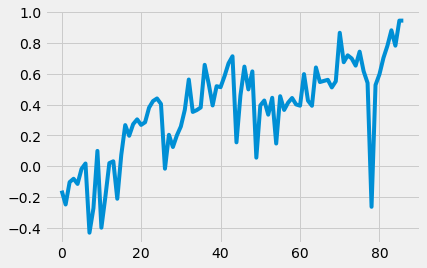

In [38]:
plt.plot(Ns[29176])
plt.plot()

In [ ]:
signals = [34900, 28490, 37520, 36659, 42193, 30546, 34313, 38980, 30237, 33451, 22367, 24713, 22961, 25887, 28509]
non_signals = [47521, 40813, 47557, 47841, 49882, 43172, 48141, 41143, 45777, 44317,5842, 42256, 44879, 39398 ,46649]

In [29]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [45]:
%.3f'%(1324343032.324325235)

UsageError: Line magic function `%.3f'%(1324343032.324325235)` not found.


In [56]:
 n_components_u

12

In [44]:
uu_kurtosis = {}
vv_kurtosis = {}

for n in range(n_components_u):
    uu_kurtosis[n] = round(kurtosis(S_u_t[n,:]), 2 )
    
for n in range(n_components_v):
    vv_kurtosis[n] = round(kurtosis(S_v_t[n,:]), 2 )

uu_kurtosis = dict(sorted(uu_kurtosis.items(), key=lambda x:x[1]))
vv_kurtosis = dict(sorted(vv_kurtosis.items(), key=lambda x:x[1]))

In [31]:
uu_kurtosis

{5: 2.78,
 11: 3.42,
 6: 4.77,
 4: 5.0,
 10: 8.79,
 9: 11.29,
 2: 11.55,
 8: 13.9,
 3: 17.03,
 7: 18.87,
 0: 30.19,
 1: 41.77}

In [45]:
list(uu_kurtosis.keys())
#list(uu_kurtosis.values())

[5, 11, 6, 4, 10, 9, 2, 8, 3, 7, 0, 1]

In [68]:
plt.set_cmap('viridis')

<Figure size 432x288 with 0 Axes>

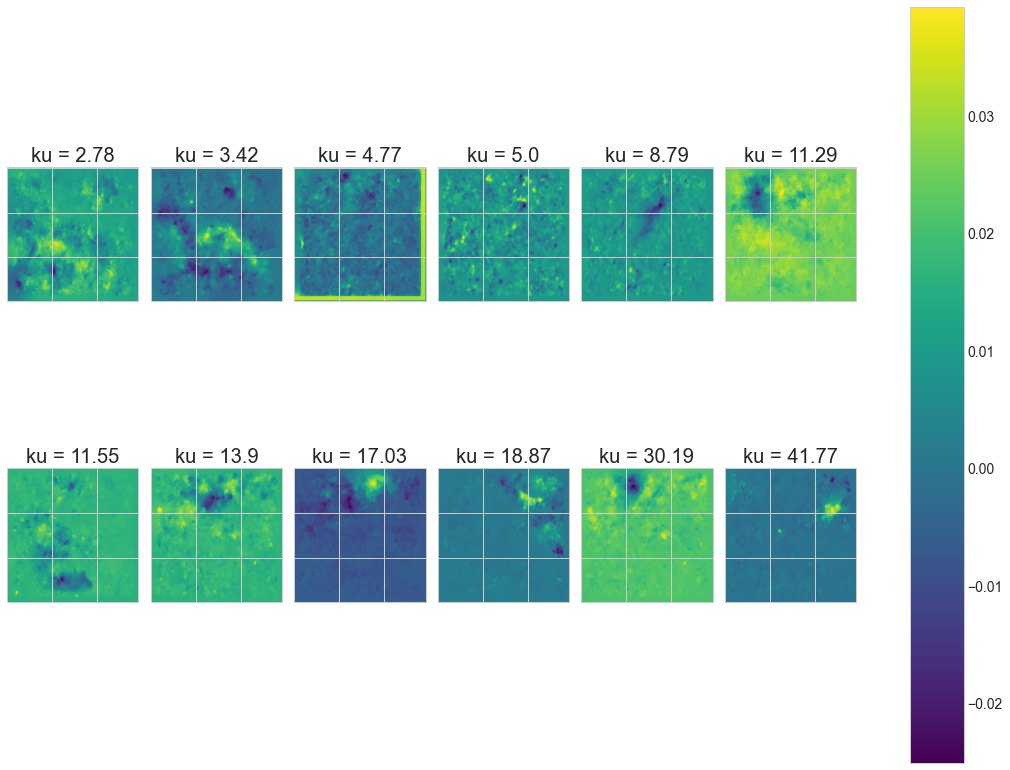

In [70]:
#plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(6, 3)
gs1.update(wspace=0.025, hspace=0)
num_rows = 2
num_cols = 6
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
uu_orders = list(uu_kurtosis.keys())
count = 0
for num_row in range(num_rows):
    for num_col in range(num_cols):
        if num_row*num_cols + num_col < num_cols *  num_rows :
            k = num_row*num_cols + num_col
            plt.axis('on')
            m = uu_orders[count]
            axs[num_row, num_col].imshow(np.reshape(S_u_t[m,:], (np.size(UU,1), np.size(UU,2))))
            axs[num_row, num_col].set_title('ku = ' + str(  round(kurtosis(S_u_t[m,:]), 2   ))  )
            axs[num_row, num_col].set_aspect('equal')
            axs[num_row, num_col].set_xticklabels([])
            axs[num_row, num_col].set_yticklabels([])
            plt.tight_layout()
            count += 1
            
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[num_row, num_col].imshow(np.reshape(S_u_t[m,:], (np.size(UU,1), np.size(UU,2)))), cax=cbar_ax, shrink=0.3)

plt.savefig("est_ouest.png")
plt.show()

In [57]:
plt.set_cmap('viridis')

<Figure size 432x288 with 0 Axes>

In [58]:
#plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(6, 3)
gs1.update(wspace=0.025, hspace=0)
num_rows = 
num_cols = 6
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
vv_orders = list(vv_kurtosis.keys())
count = 0
for num_row in range(num_rows):
    for num_col in range(num_cols):
        if num_row*num_cols + num_col < num_cols *  num_rows :
            k = num_row*num_cols + num_col
            plt.axis('on')
            m = vv_orders[count]
            axs[num_row, num_col].imshow(np.reshape(S_v_t[m,:], (np.size(UU,1), np.size(UU,2))))
            axs[num_row, num_col].set_title('kr = ' + str(  round(kurtosis(S_v_t[m,:]), 2   ))  )
            axs[num_row, num_col].set_aspect('equal')
            axs[num_row, num_col].set_xticklabels([])
            axs[num_row, num_col].set_yticklabels([])
            plt.tight_layout()
            count += 1
plt.savefig("est_ouest.png")
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_2320/3800838440.py, line 5)

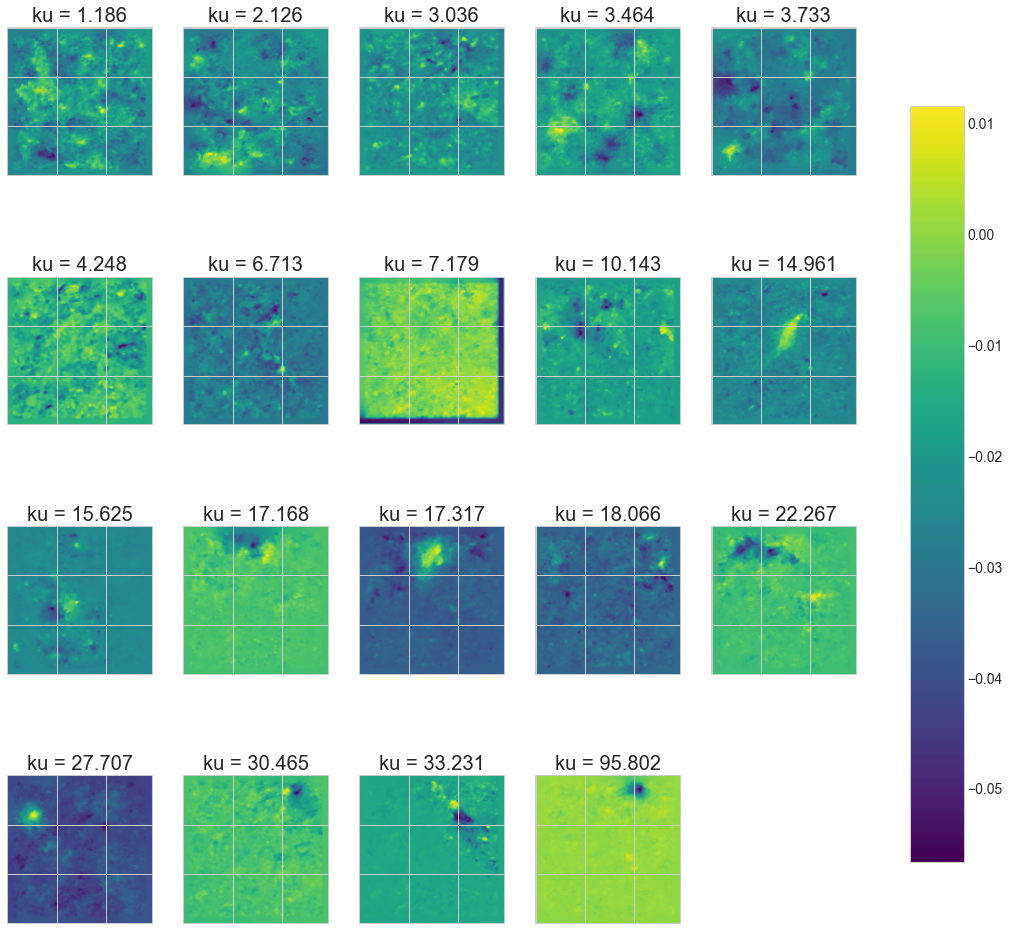

In [59]:
#plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(6, 3)
gs1.update(wspace=0.025, hspace=0)
num_rows = 4
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))
vv_orders = list(vv_kurtosis.keys())
count = 0
for num_row in range(num_rows):
    for num_col in range(num_cols):
        if num_row*num_cols + num_col < num_cols *  num_rows :
            k = num_row*num_cols + num_col
            plt.axis('on')
            if k < 19:
                m = vv_orders[count]
                axs[num_row, num_col].imshow(np.reshape(S_v_t[m,:], (np.size(UU,1), np.size(UU,2))), cmap='viridis')
                axs[num_row, num_col].set_title('ku = ' + str(  round(kurtosis(S_v_t[m,:]), 3   ))  )
                axs[num_row, num_col].set_aspect('equal')
                axs[num_row, num_col].set_xticklabels([])
                axs[num_row, num_col].set_yticklabels([])
                plt.tight_layout()
                count += 1
                
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(axs[num_row, num_col].imshow(np.reshape(S_v_t[m,:], (np.size(UU,1), np.size(UU,2)))), cax=cbar_ax, shrink=0.5)
fig.delaxes(axs[num_row, num_col])
plt.savefig("nord_sud.png")
plt.show()

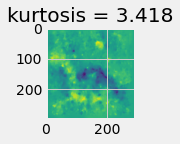

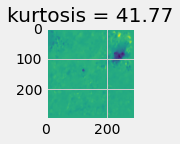

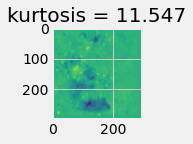

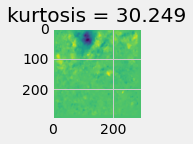

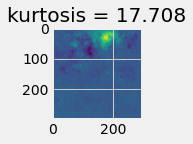

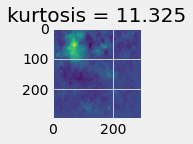

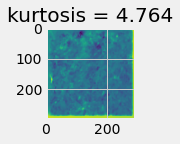

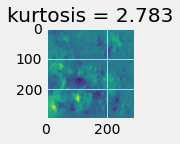

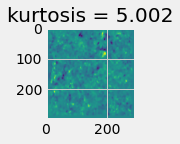

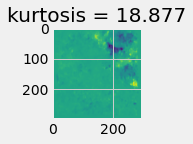

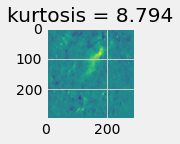

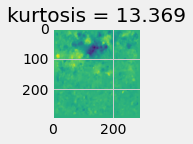

In [71]:
for k in range(0, n_components_u):
    plt.figure(figsize=(10, 10))
    if k + 1 <= 6 :
        plt.subplot(1,6,k+1)
        plt.imshow(np.reshape(S_u_t[k,:], (np.size(UU,1), np.size(UU,2))))
        plt.title('kurtosis = ' + str(  round(kurtosis(S_u_t[k,:]), 3   ))  )
    else :
        plt.subplot(2,6,k+1)
        plt.imshow(np.reshape(S_u_t[k,:], (np.size(UU,1), np.size(UU,2))))
        plt.title('kurtosis = ' + str(  round(kurtosis(S_u_t[k,:]), 3   ))  )
                  
plt.show()

In [ ]:
def plot_series(series, num_rows=48677, num_cols=5, colormap='tab20'):
        
    plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(25,25))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]
    
    for num_row in range(num_rows):
        for num_col in range(num_cols):
            if num_row*num_cols + num_col < len(series):
                axs[num_row, num_col].imshow()
                    #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))
        plt.show()

In [ ]:
# trier les sources dans l'ordre croissant de leur kurtosis
kurtosis_u = {}
kurtosis_v = {}
for n in range(n_components):
    kurtosis_u[n] = kurtosis(S_u_t[n,:])
    kurtosis_v[n] = kurtosis(S_v_t[n,:])
kurtosis_u_sorted = {k: v for k, v in sorted(kurtosis_u.items(), key=lambda item: item[1])}
kurtosis_v_sorted = {k: v for k, v in sorted(kurtosis_v.items(), key=lambda item: item[1])}

In [ ]:
k = 1
plt.imshow(S_u_t[k, :].reshape((UU.shape[1], UU.shape[2])))
plt.title(kurtosis(S_u_t[k, :]))
plt.colorbar()
plt.show()

In [ ]:
from scipy import ndimage, misc

In [ ]:
from scipy.stats import norm, kurtosis

In [ ]:
# ajouter progressivement le sources et observer le comportement des séries temporelles ?
NS_, EW_ = [], []
for k, v in kurtosis_u_sorted.items():
    
    S_u_c = S_u[:, :]
    S_v_c = S_v[:, :]
    
    for n in range(S_u.shape[1]):
        if k != n:
            S_u_c[:, n] = 0
            S_v_c[:, n] = 0
            
    Iu_f = None
    Iv_f = None
    Ew_ = []
    Ns_ = []
    Iv_f = np.dot(np.transpose(dv), S_v_c.T).T
    Iu_f = np.dot(np.transpose(du), S_u_c.T).T

    for i in range(Iu_f.shape[0]):
            Ew.append(np.cumsum(Iu_f[i, :]))
            Ns.append(np.cumsum(Iv_f[i, :]))
    EW_.append(Ew)
    NS_.append(Ns)

# Détermination du nombre de sources

In [ ]:
def estimate_nsources(G, data, start=10, step=5, max_iter=100, ica_tol=0.001, dt_tol=0.01):
    
    for i range(max_iter):
        n_components = start + i * step
        ica = FastICA(n_components=n_components, whiten='boolean', tol=ica_tol)        
        sources = ica.fit_transform(data)  
        sources_t = np.transpose(sources)
        A = ica.mixing_
        
        du = []
        dv = []
        
        for i in range(0, n_components):
            du.append(G.dot(A[:, i]))
            dv.append(G.dot(A[:, i]))
            
        I, C = [], []
        
        I = np.dot(np.transpose(dv), sources.T).T

        for i in range(I.shape[0]):
            C.append(np.cumsum(I[i, :]))
        
        for n in range(len(C)):
            
import random
def seek_number_sources(data, n_components_min, n_componets_max, step=5, max_iter=100, tol=0.0001, seed=1000, max_value=1000):
    
    np.random(seed)
    random_states = random.sample(range(max_value), max_iter)
    components = []
    
    for n_components in range(n_components_min, n_componets_max, step):
        for n_iter in range(max_iter):
            ica = FastICA(n_components=n_components, whiten='boolean', tol=tol)
            components_iter.transpose(ica.fit_transform(data))
            

In [121]:
import random
from scipy.stats import pearsonr
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats

def seek_number_sources(data, n_components_min=2, n_components_max=30, step=1, max_iter=100, ica_max_iter=300, seed=1000, max_value=1000):
    
    random.seed(seed)
    random_states = random.sample(range(max_value), max_iter)
    cluster_qualities, mixings, labels = [], [], []

    # génération des composantes indépendantes
    for n_components in range(n_components_min, n_components_max, step):
        components = []
        print(n_component)
        for n_iter in range(max_iter):
            ica = FastICA(n_components=n_components, random_state=random_states[n_iter], max_iter=ica_max_iter)
            components_iter = np.transpose(ica.fit_transform(data))
            for rw in np.transpose(ica.mixing_):
                mixings.append(list(rw))
            #components.append(components_iter)
        # compute similarity matrix
        # X = np.transpose(np.array(components)).reshape((n_components * max_iter, -1))
        
    return np.array(mixings)

def compute_similarity_matrix(data, metric='pearson'):
        size = len(data)
        distances_matrix = np.zeros(shape=(size, size))
        
        for n in range(size):
            for m in range(n + 1, size):
                r = 1 - abs(pearsonr(data[n], data[m])[0]) # attention aux valeurs négatives !
                distances_matrix[m, n] = r
                distances_matrix[n, m] = r
                
        return distances_matrix
    
def average_intra_cluster_similarity(data, labels, num_cluster):
    r = 0.0
    object_indexes = np.where(labels == num_cluster)[0]
    card_cluster = object_indexes.shape[0]
    for i in range(card_cluster):
        for j in range(i, card_cluster):
            n, m = object_indexes[i], object_indexes[j]
            #r += pearsonr(data[n], data[m])[0]
            r += abs(pearsonr(data[n], data[m])[0])
            #r += - distances[object_indexes[i], object_indexes[j]] + 1
    return  r / (card_cluster * card_cluster)

def average_inter_cluster_similarity(data, labels, num_cluster):
    r = 0.0
    object_indexes = np.where(labels == num_cluster)[0]
    non_object_indexes = np.where(labels != num_cluster)[0]
    card_cluster = object_indexes.shape[0]
    for i in range(object_indexes.shape[0]):
        for j in range(non_object_indexes.shape[0]):
            n, m = object_indexes[i], non_object_indexes[j]
            r += abs(pearsonr(data[n], data[m])[0])
           # r += stats.spearmanr(data[n], data[m])[0]
    
    return r / (card_cluster * (labels.shape[0] - card_cluster))

def cluster_quality(data, labels, num_cluster):
    avg_inter_sm = average_inter_cluster_similarity(data, labels, num_cluster)
    avg_intra_sm = average_intra_cluster_similarity(data, labels, num_cluster)
    return avg_intra_sm - avg_inter_sm

# à modifier
def average_clustering_quality(data, labels , n_clusters):
    avg = 0.0
    for num_cluster in range(n_clusters):
        avg +=  cluster_quality(data, labels, num_cluster)
    return avg / n_clusters

In [ ]:
model = AgglomerativeClustering(affinity='precomputed', n_clusters=10, linkage='average').fit(distances)
l = average_clustering_quality(X1, model.labels_, 10)

In [ ]:
# lorsque le clustering est parfait, on a Iq(Ck) = 1 c'est à dire le premier terme vaut 1 et le second terme vaut zero
# par conséquent le premier doit augmenter et le second terme diminuer au cours de chaque iteration

In [122]:
X1 = seek_number_sources(uu_4ica, n_components_min=2, n_components_max=51, step=1, max_iter=60)
with open('x1uu.pkl','wb') as f:
    pickle.dump(X1, f)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


2


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastic

2


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastic

2


c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
c:\users\plateforme_gt\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


KeyboardInterrupt: 

In [123]:
def benchmark_validation(X1, distances, n_components_min, n_components_max, step):
    
    dunn, sc, pearson = [], [], []
    # clusteriser les données pour chaque nombre de composantes testées
    for n_clusters in range(n_components_min, n_components_max, step):
        model = AgglomerativeClustering(affinity='precomputed', n_clusters=n_clusters, linkage='average').fit(distances)
        labels = model.labels_
        # coefficient de silhouette
        print('coefficient de silhouette')
        sc.append(silhouette_score(distances, labels, metric='precomputed'))
        # indice de DUNN
        # indice prédéfini
        print('coefficient de pearson absolute')
        pearson.append(average_clustering_quality(X1, labels, n_clusters))
        
    return dunn, sc, pearson

In [ ]:
uu_distances = compute_similarity_matrix(UU_X1)

In [124]:
_, uu_sc, uu_pearson = benchmark_validation(UU_X1, uu_distances, 2, 30, 1)

NameError: name 'uu_distances' is not defined

In [141]:
X2 = seek_number_sources(vv_4ica, n_components_min=2, n_components_max=30, step=1, max_iter=100)
import pickle
with open('x2vv.pkl','wb') as f:
    pickle.dump(X2, f)

2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


KeyboardInterrupt: 

In [27]:
import pickle

with open('x1uu.pkl', 'rb') as f:
    UU_X1 = pickle.load(f)
    
with open('x2vv.pkl', 'rb') as f:
    VV_X2 = pickle.load(f)

In [134]:
def validate(data, n_components_min, n_components_max, n_iterations, ward=True):
    
    start = 0
    pearson, silhouette = [], []

    for n_components in range(n_components_min, n_components_max, 1):
        end  = start + n_components * n_iterations
        X = data[start:end, :]
        distances = compute_similarity_matrix(X)
        results = None
        if not ward:
            results = AgglomerativeClustering(affinity='precomputed', n_clusters=n_components, linkage='average').fit(distances)
        else:
            results = AgglomerativeClustering(n_clusters=n_components).fit(X)
            print('ward')
        pearson.append(average_clustering_quality(X, results.labels_, n_components))
        silhouette.append(silhouette_score(distances, results.labels_, metric='precomputed'))
        print('%d finished' % n_components)
        start = end + 1
        
    return pearson, silhouette

In [135]:
uu_pearson, uu_silhouette = validate(UU_X1, 2, 30, 50, ward=True)



ward
2 finished
ward
3 finished
ward
4 finished
ward
5 finished
ward
6 finished
ward
7 finished
ward
8 finished
ward
9 finished
ward
10 finished
ward
11 finished
ward
12 finished
ward
13 finished
ward
14 finished
ward
15 finished
ward
16 finished
ward
17 finished
ward
18 finished
ward
19 finished
ward
20 finished
ward
21 finished
ward
22 finished
ward
23 finished
ward
24 finished
ward
25 finished
ward
26 finished
ward
27 finished
ward
28 finished
ward
29 finished


In [66]:
vv_pearson, vv_silhouette = validate(VV_X2, 2, 30, 50)

(100, 1612)
2 finished
(150, 1612)
3 finished
(200, 1612)
4 finished
(250, 1612)
5 finished
(300, 1612)
6 finished
(350, 1612)
7 finished
(400, 1612)
8 finished
(450, 1612)
9 finished
(500, 1612)
10 finished
(550, 1612)
11 finished
(600, 1612)
12 finished
(650, 1612)
13 finished
(700, 1612)
14 finished
(750, 1612)
15 finished
(800, 1612)
16 finished
(850, 1612)
17 finished
(900, 1612)
18 finished
(950, 1612)
19 finished
(1000, 1612)
20 finished
(1050, 1612)
21 finished
(1100, 1612)
22 finished
(1150, 1612)
23 finished
(1200, 1612)
24 finished
(1250, 1612)
25 finished
(1300, 1612)
26 finished
(1350, 1612)
27 finished
(1400, 1612)
28 finished
(1423, 1612)
29 finished


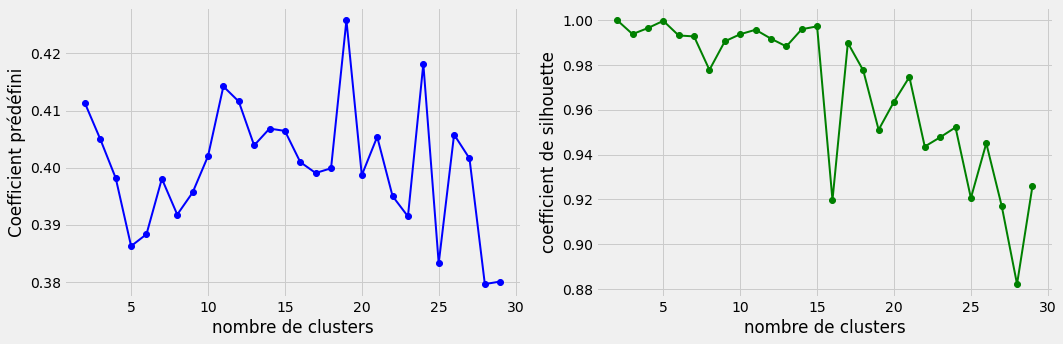

In [106]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(n_components_min, n_components_max, 1), vv_pearson, marker='o', color='b', linewidth=2)
plt.xlabel('nombre de clusters')
plt.ylabel('Coefficient prédéfini')
plt.subplot(1,2,2)
plt.plot(np.arange(n_components_min, n_components_max, 1), vv_silhouette, marker='o', color='g', linewidth=2)
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.tight_layout()
plt.savefig('vv_validation.png')
plt.show()

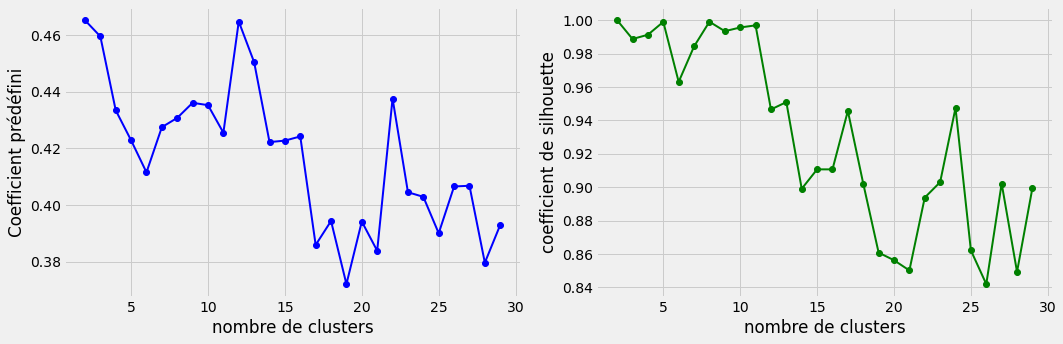

In [103]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(n_components_min, n_components_max, 1), uu_pearson, marker='o', color='b', linewidth=2)
plt.xlabel('nombre de clusters')
plt.ylabel('Coefficient prédéfini')
plt.subplot(1,2,2)
plt.plot(np.arange(n_components_min, n_components_max, 1), uu_silhouette, marker='o', color='g', linewidth=2)
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.tight_layout()
plt.savefig('uu_validation.png')
plt.show()

In [54]:
distances = compute_similarity_matrix(UU_X1)

KeyboardInterrupt: 

In [ ]:
# normaliser chaque ligne de la matrice
UU_X1_norm = []
VV_X2_norm = []
for n in range(UU_X1.shape[0]):
    UU_X1_norm.append( (UU_X1[n] - UU_X1[n].mean()) / UU_X1[n].std() )
    VV_X2_norm.append( (VV_X2[n] - VV_X2[n].mean()) / VV_X2[n].std() )

In [ ]:
scores = []
for n_clusters in range(2, 30, 1):
    print(n_clusters)
    model = AgglomerativeClustering(n_clusters=n_clusters)
    results = model.fit(UU_X1_norm)
    scores.append(silhouette_score(UU_X1_norm, results.labels_))

In [ ]:
vv_scores = []
for n_clusters in range(2, 30, 1):
    print(n_clusters)
    model = AgglomerativeClustering(n_clusters=n_clusters)
    results = model.fit(VV_X2_norm)
    vv_scores.append(silhouette_score(VV_X2_norm, results.labels_))

In [ ]:
plt.plot(np.arange(2, 30, 1), scores)
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.tight_layout()
plt.savefig('sc_scores_uu')
plt.show()

In [ ]:
_, uu_sc, uu_pearson = benchmark_validation(X1, distances, 2, 30, 1)

In [ ]:
def init_worker(components, shape, n_proc):
    global VAR_DICT
    VAR_DICT['components'] = components
    VAR_DICT['shape'] = shape
    VAR_DICT['n_proc'] = n_proc
    
def compute_pearson(rank, n, m)
    if 
    return 1 - abs(pearsonr(X[n], X[m])[0])

# Distrubution de la kurtosis en fonction du nombre de sources

In [ ]:
kurtosis_u_t, kurtosis_v_t = [], []
nsources = [20, 30, 40, 50, 60, 70, 80, 90]
#nsources = [20, 30]

for n in range(len(nsources)):
    
    icav = FastICA(n_components=nsources[n], whiten='boolean', tol=1)
    icau = FastICA(n_components=nsources[n], whiten='boolean', tol=1)

    S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
    S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
    S_v_t = np.transpose(S_v)
    S_u_t = np.transpose(S_u)
    A_v = icav.mixing_
    A_u = icau.mixing_
    
    kurtosis_u = []
    kurtosis_v = []
    
    for m in range(nsources[n]):
        kurtosis_u.append(kurtosis(S_u_t[m,:]))
        kurtosis_v.append(kurtosis(S_v_t[m,:]))
    
    kurtosis_u_t.append(kurtosis_u)
    kurtosis_v_t.append(kurtosis_v)
    
    print('Execution with n = %d completed' % nsources[n])

# Création des données de base

In [ ]:
n_components = 30
icav = FastICA(n_components=n_components, whiten='boolean', tol=0.01)
icau = FastICA(n_components=n_components, whiten='boolean', tol=0.01)
S_v = icav.fit_transform(vv_4ica)  # Reconstruct signals
S_u = icau.fit_transform(uu_4ica)  # Reconstruct signals
S_v_t = np.transpose(S_v)
S_u_t = np.transpose(S_u)
A_v = icav.mixing_
A_u = icau.mixing_

du = []
dv = []
for i in range(0, n_components):
    du.append(AA.dot(A_u[:, i]))
    dv.append(AA.dot(A_v[:, i]))
    
Iu_f = None
Iv_f = None
Ew = []
Ns = []
Iv_f = np.dot(np.transpose(dv), S_v.T).T
Iu_f = np.dot(np.transpose(du), S_u.T).T
    
for i in range(Iu_f.shape[0]):
        Ew.append(np.cumsum(Iu_f[i, :]))
        Ns.append(np.cumsum(Iv_f[i, :]))

In [ ]:
# trier les sources dans l'ordre croissant de leur kurtosis
kurtosis_u = {}
kurtosis_v = {}
for n in range(n_components):
    kurtosis_u[n] = kurtosis(S_u_t[n,:])
    kurtosis_v[n] = kurtosis(S_v_t[n,:])
kurtosis_u_sorted = {k: v for k, v in sorted(kurtosis_u.items(), key=lambda item: item[1])}
kurtosis_v_sorted = {k: v for k, v in sorted(kurtosis_v.items(), key=lambda item: item[1])}

# Génération des données synthétiques

# Labellisation des données

# Construction d'un réseau de neurones convolutif

# Entrainement et évaluation des performances